<a href="https://colab.research.google.com/github/canamac/zeka-can/blob/main/OA_S_R_Power_CokluHisse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

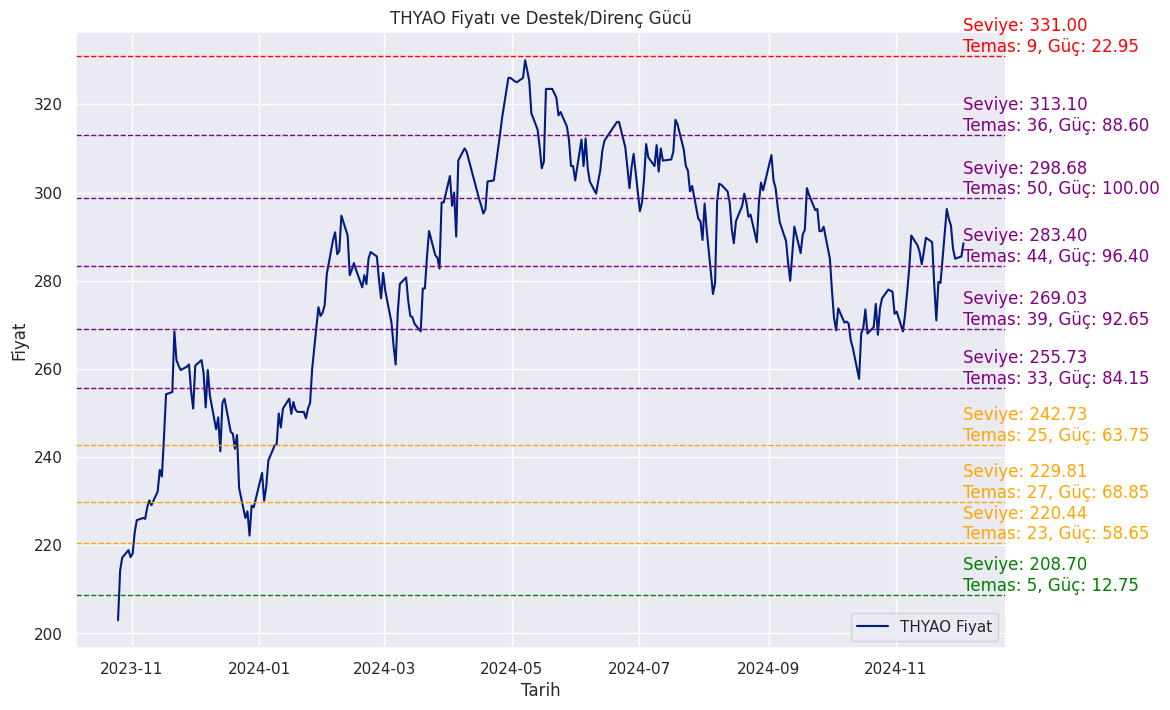

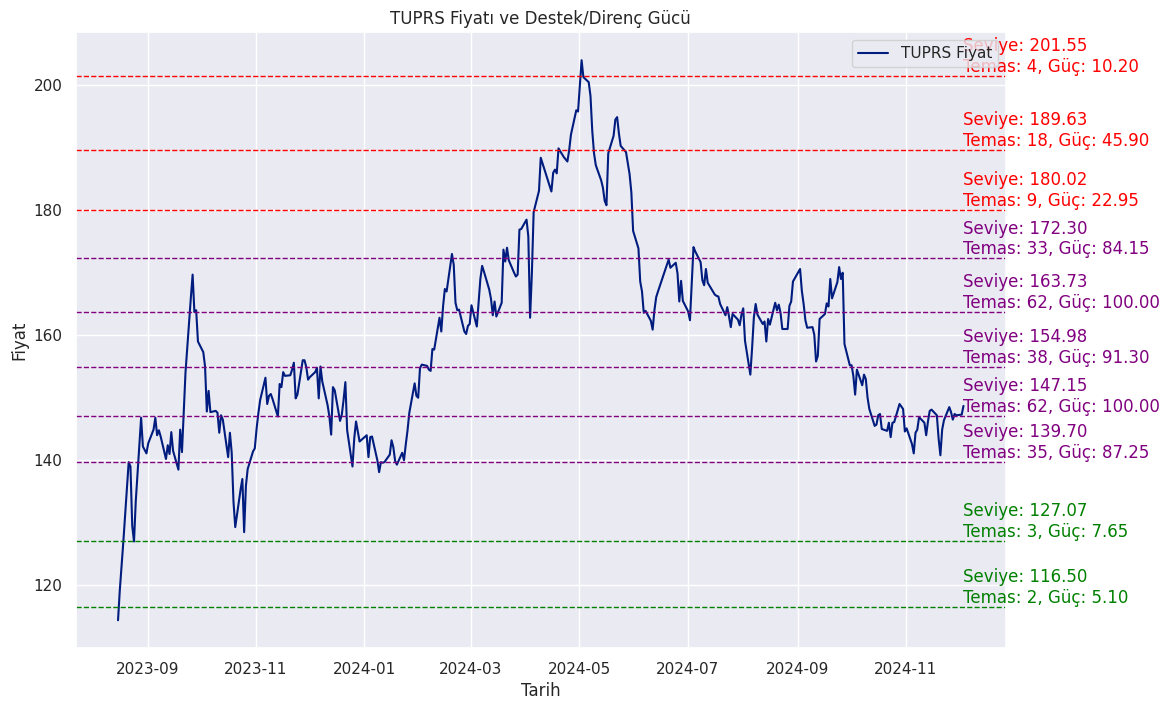

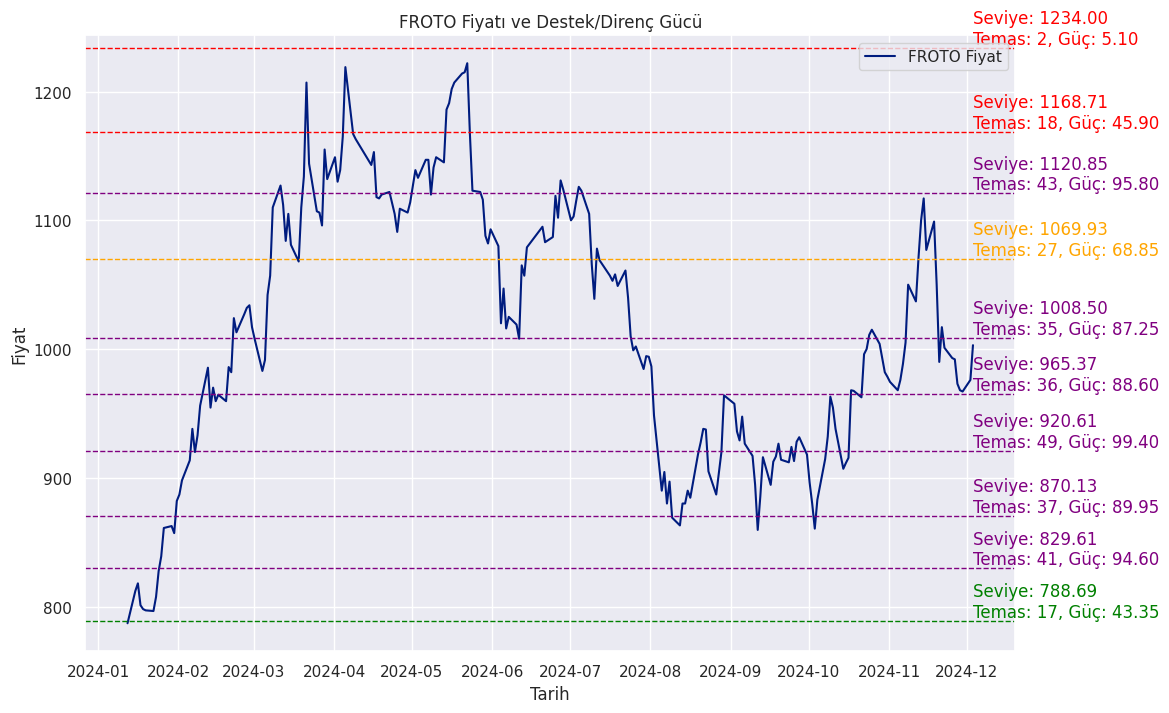

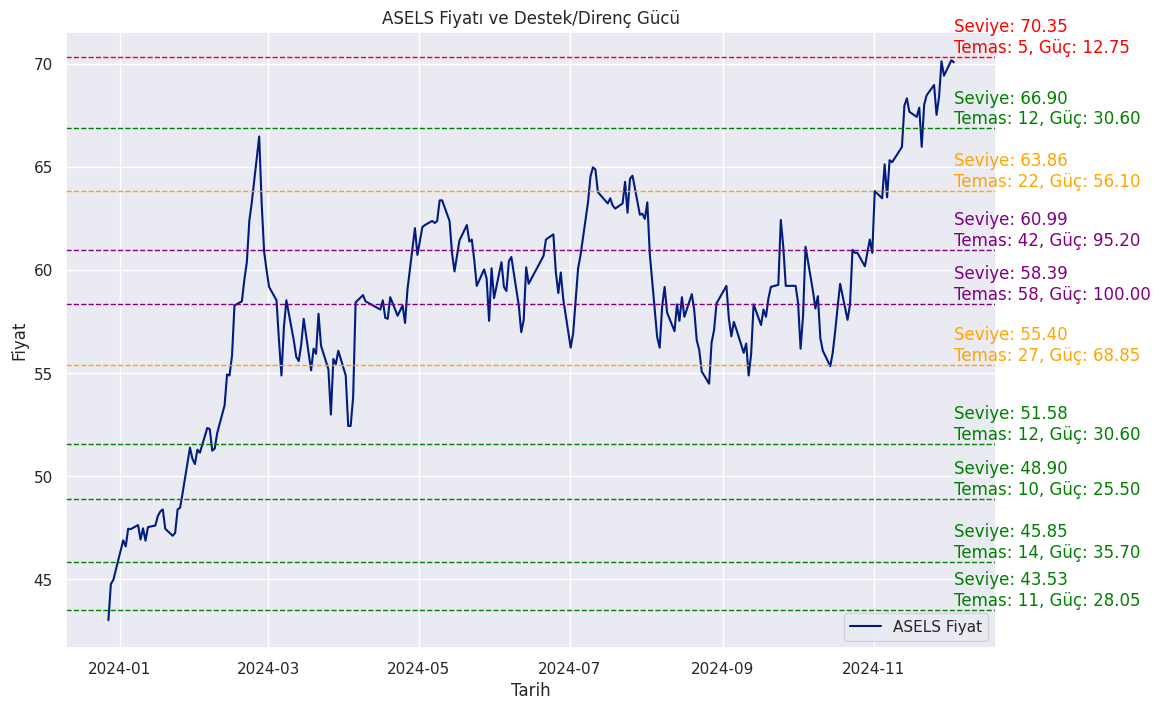

In [ ]:
# KÜTÜPHANELERİ YÜKLEME
import subprocess
subprocess.run(["pip", "install", "git+https://github.com/rongardF/tvdatafeed ", "--quiet"])
subprocess.run(["pip", "install", "tradingview-screener", "--quiet"])
subprocess.run(["pip", "install", "mplfinance", "--quiet"])
import logging
logging.getLogger('tvDatafeed.main').setLevel(logging.ERROR)
import yfinance as yf
import matplotlib.pyplot as plt
import mplfinance as mpf
import seaborn as sns
import numpy as np
import pandas as pd
from tvDatafeed import TvDatafeed, Interval
from tradingview_screener import get_all_symbols
import warnings
warnings.filterwarnings('ignore')

# Indikatör Parametreleri
width = 1
percent_range = 5.0
touch_percent = 1.0
timeframes = 'D' # Günlük
number_of_lines = 10
length_momentum = 14
volume_weight = 0.3
bounce_weight = 0.4
retest_weight = 0.3
secilenHisseler = ["THYAO", "TUPRS", "FROTO", "ASELS"]

# Peak ve Valley Hesaplama
def calc_peak_valley(data, width):
    peak_counter = 0
    valley_counter = 0
    for i in range(0, width * 2 + 1):
        if i != width:
            peak_counter += 1 if data['High'].iloc[-1-i] < data['High'].iloc[-1-width] else 0
            valley_counter += 1 if data['Low'].iloc[-1-i] > data['Low'].iloc[-1-width] else 0
    peak_level = data['High'].iloc[-1-width] if peak_counter == width * 2 else None
    valley_level = data['Low'].iloc[-1-width] if valley_counter == width * 2 else None
    return peak_level, valley_level

# Strength Hesaplama
def calc_strength(price_level, touches, volume_weight=volume_weight, bounce_weight=bounce_weight, retest_weight=retest_weight):
    vol_strength = min(touches * 2, 100) * volume_weight
    bounce_strength = min(touches * 3, 100) * bounce_weight
    retest_strength = min(touches * 2.5, 100) * retest_weight
    strength = vol_strength + bounce_strength + retest_strength
    return min(max(strength, 0), 100)

# Seviye Renklerine Karar Verme
def get_level_color(strength, price_level, close):
    # Determine the color based on the strength and price_level
    if strength is None:
        result = 'gray'
    elif strength >= 70:
        result = 'purple'
    elif 50 <= strength < 70:
        result = 'orange'
    elif price_level > close:
        result = 'red'
    else:
        result = 'green'
    return result

# Secilen Hisseler İçin Ana Indikatorü Çağırma
for hisse in secilenHisseler:
  # Geçmiş Veri Çekme
  ticker = hisse
  exchange = "BIST"

  tv = TvDatafeed()
  data = tv.get_hist(symbol=ticker,exchange=exchange,interval=Interval.in_daily,n_bars=5000)
  data.rename(columns = {'open':'Open', 'high':'High','low':'Low','close':'Close','volume':'Volume'}, inplace = True)
  data.index = data.index.tz_localize('UTC').tz_convert('Europe/Istanbul')

  # ANA FONKSİYON
  peaks = []
  valleys = []
  for i in range(width, len(data) - width):
      peak, valley = calc_peak_valley(data.iloc[i-width:i+width+1], width)
      if peak is not None:
          peaks.append(peak)
      if valley is not None:
          valleys.append(valley)

  peak_valley = sorted(peaks + valleys)
  filtered_peak_valley = []
  prev_value = None
  total = 0
  counter = 0

  for current_value in peak_valley:
      if prev_value is None:
          prev_value = current_value
          total = current_value
          counter = 1
      else:
          percent_diff = abs(current_value - prev_value) / prev_value * 100
          if percent_diff <= percent_range:
              total += current_value
              counter += 1
          else:
              if counter > 0:
                  average = total / counter
                  filtered_peak_valley.append(average)
              prev_value = current_value
              total = current_value
              counter = 1
  if counter > 0:
      average = total / counter
      filtered_peak_valley.append(average)

  filtered_peak_valley[-number_of_lines:]
  last_price_values = filtered_peak_valley[-number_of_lines:]
  high_low = data['High'].tolist() + data['Low'].tolist()

  level_strengths = []
  level_touches = []

  for price_value in last_price_values:
      pv_counter = 0
      for high_low_values in high_low:
          percent_diff = (price_value-high_low_values) / price_value * 100
          if -touch_percent <= percent_diff and percent_diff <= touch_percent:
              pv_counter += 1

      strength = calc_strength(price_value, pv_counter)
      level_strengths.append(strength)
      level_touches.append(pv_counter)

  # GRAFİK ÇİZİMİ
  y_axis_min = min(last_price_values)
  first_below_index = next((index for index, value in reversed(list(enumerate(data['Close']))) if value < y_axis_min), data.index[0])
  plotData = data[first_below_index:]

  sns.set_theme(style='darkgrid', context='notebook', palette='dark')

  plt.figure(figsize=(12, 8))
  # Fiyat Çizgisi
  plt.plot(plotData['Close'], label=f'{ticker} Fiyat')
  for price_value, strength, level_touch in zip(last_price_values, level_strengths, level_touches):
      color = get_level_color(strength, price_value, plotData['Close'].iloc[-1])
      # Yatay Çizgiler
      plt.axhline(y=price_value, color=color, linestyle='--', linewidth=1)
      plt.text(plotData.index[-1], price_value, f'Seviye: {price_value:.2f} \nTemas: {level_touch}, Güç: {strength:.2f}', color=color, verticalalignment='bottom', fontsize=12)

  plt.title(f'{ticker} Fiyatı ve Destek/Direnç Gücü')
  plt.xlabel('Tarih')
  plt.ylabel('Fiyat')
  plt.legend()
  plt.show()
